# Transcription factor binding analysis with convolutional networks

In this tutorial, we will walk through a simple tensorflow example of how to build, train, and evaluate a convolutional neural network for a common supervised classification learning task of predicting whether or not a TF binds to a given sequence. 

In [1]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import os, sys, h5py
import numpy as np
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
%matplotlib inline

import tensorflow as tf

# load CTCF dataset

CTCF conservative narrow peaks were downloaded from the ENCODE database:
https://www.encodeproject.org/experiments/ENCSR000BIE/

!wget https://www.encodeproject.org/files/ENCFF252PLM/@@download/ENCFF252PLM.bed.gz

The peaks were processed with a script (process_chip.py), whose steps include:
    1. enforce a constant window about each peak (window size = 100 nts)
    2. employ bedtools to extract sequences from GRC38 reference genome
    3. filter sequences which contain `N' characters
    4. convert sequences into a one-hot representation
    5. generate background sequences by performing a dinucleotide shuffle using meme
    6. combine and shuffles positive and negative sequences
    7. create a label vector with either a one for sequences that has a ChIP-seq peak and a zero for di-nuc shuffled sequences
    8. split the dataset into a training set, validation set, and test set
    9. save dataset to a hdf5 file

In [2]:
# path to dataset 
data_file_path = '../data/CTCF_100.h5'

# load dataset
dataset = h5py.File(data_file_path, 'r')
X_train = np.array(dataset['X_train']).astype(np.float32)
Y_train = np.array(dataset['Y_train']).astype(np.float32)
X_valid = np.array(dataset['X_valid']).astype(np.float32)
Y_valid = np.array(dataset['Y_valid']).astype(np.float32)
X_test = np.array(dataset['X_test']).astype(np.float32)
Y_test = np.array(dataset['Y_test']).astype(np.float32)

# add another dimension to make it a 4D tensor and 
# transpose dimensions so that it matches convolutional layer inputs:
#                  (batch size, sequence length, 1, nucleotide channels)
#    Note: adding an additional dimension is required because we will be using 2D convolution functions,
#          because tensorflow doesn't support a lot of functions for 1D sequences.  Effectively, its like
#          treating second dimension as an image with one pixel in one axis.
X_train = np.expand_dims(X_train, axis=3).transpose([0, 2, 3, 1])
X_test = np.expand_dims(X_test, axis=3).transpose([0, 2, 3, 1])
X_valid = np.expand_dims(X_valid, axis=3).transpose([0, 2, 3, 1])

# get shapes of data
num_data, seq_length, _, dims = X_train.shape

# build our convolutional neural network model 

Our model will be similar to DeepBind: one convolutional layer, one fully-connected hidden layer, followed by an output layer.  

In [3]:
# reset graphs --> this is necessary if you accidentally build multiple graphs, 
#                  then the other graphs will also save as will the other graph's parameters. 
tf.reset_default_graph()

# functions for initializations also known as inits
def he_init(shape):
    """He inits are designed for neural networks that employ ReLU activations."""
    fan_in = shape[0]
    fan_out = shape[1]
    stddev = np.sqrt(2.6/fan_in)
    return tf.truncated_normal(shape=shape, mean=0.0, stddev=stddev, dtype=tf.float32)

def const_init(shape, value=0.0):
    """constant inits are useful for bias terms"""
    return tf.constant(shape=shape, value=value, dtype=tf.float32)

# create a placeholder for the data
inputs = tf.placeholder(tf.float32, shape=[None, seq_length, 1, dims], name='inputs')

# build the first convolutional layer
num_filters = 16
filter_size = 19
strides = 1
W1 = tf.Variable(he_init(shape=[filter_size, 1, dims, num_filters]), name='W1')
b1 = tf.Variable(const_init(shape=[num_filters], value=0.01), name='b1')
conv_1 = tf.nn.conv2d(inputs, 
                      filter=W1, 
                      strides=[1, strides, 1, 1], 
                      padding='SAME')

# add bias term
conv_1_bias = tf.nn.bias_add(conv_1, b1)

# perform activation
conv_1_active = tf.nn.relu(conv_1_bias)

# downsample data with max-pooling
pool_size = 25
conv_1_pool = tf.nn.max_pool(conv_1, 
                             ksize=(1,pool_size,1,1), 
                             strides=(1,pool_size,1,1), 
                             padding='SAME')

#keep_prob = tf.placeholder(tf.bool, name='keep_prob')
#conv_1_dropout = tf.nn.dropout(conv_1_pool, keep_prob=keep_prob)

# get number of input neurons
num_incoming = np.prod(conv_1_pool.get_shape()[1:]).value

# reshape convolutional outputs to a vector
conv_1_flat = tf.reshape(conv_1_pool, shape=(-1,num_incoming))

# build a fully-connected layer (also known as a dense layer)
num_units = 32
W2 = tf.Variable(he_init(shape=[num_incoming, num_units]), name='W2')
b2 = tf.Variable(const_init(shape=[num_units], value=0.01), name='b2')
dense_1 = tf.matmul(conv_1_flat, W2)

# add bias term
dense_1_bias = tf.nn.bias_add(dense_1, b2)

# perform activation
dense_1_active = tf.nn.relu(dense_1_bias)

#dense_1_active_dropout = tf.nn.dropout(dense_1_active, keep_prob=keep_prob)

# build a fully-connected layer (also known as a dense layer)
W3 = tf.Variable(he_init(shape=[num_units, 1]), name='W3')
b3 = tf.Variable(const_init(shape=[1], value=0.01), name='b3')
dense_2 = tf.matmul(dense_1_active, W3)

# add bias term
dense_2_bias = tf.nn.bias_add(dense_2, b3)

# make binary predictions
predictions = tf.nn.sigmoid(dense_2_bias)


# build optimizer

In [4]:
# instantiate placeholder for labels 
targets = tf.placeholder(tf.float32, shape=[None, 1], name='targets')

# calculate binary cross-entropy loss function
eps = 1e-10
binary_cross_entropy = targets*tf.log(predictions + eps) + (1 - targets)*tf.log(1 - predictions + eps)
loss_function = tf.reduce_mean(-tf.reduce_sum(binary_cross_entropy, axis=1))
    
# get a list of all trainable variables
trainable_vars = tf.trainable_variables()

# setup optimizer
optimizer = tf.train.AdamOptimizer(learning_rate=0.0003, 
                                   beta1=0.9, 
                                   beta2=0.999)
update_vars = optimizer.minimize(loss_function, var_list=trainable_vars)

# create a session

In [5]:
sess = tf.Session()
sess.run(tf.global_variables_initializer())

# train the neural network

In [6]:
def batch_generator(X, y, batch_size=128, shuffle=True):
    if shuffle:
        indices = np.arange(len(X))
        np.random.shuffle(indices)
    for start_idx in range(0, len(X)-batch_size+1, batch_size):
        if shuffle:
            excerpt = indices[start_idx:start_idx+batch_size]
        else:
            excerpt = slice(start_idx, start_idx+batch_size)
        yield X[excerpt].astype(np.float32), y[excerpt].astype(np.float32)
        
        
num_epochs = 20        # maximum number of epochs
batch_size = 100         # mini-batch size for a parameter update
num_train_batches = X_train.shape[0] // batch_size

# training loop
for epoch in range(num_epochs):

    # make a batch ganerator for the training data
    train_batches = batch_generator(X_train, Y_train, batch_size, shuffle=True)

    # loop over training batches
    train_loss = 0
    for index in range(num_train_batches):
        # get a mini-batch
        x_batch, y_batch = next(train_batches)
        
        # update over a mini-batch
        loss, _ = sess.run([loss_function, update_vars], 
                           feed_dict={inputs: x_batch, targets: y_batch})
        train_loss += loss
        
    valid_loss, valid_predict = sess.run([loss_function, predictions], 
                                         feed_dict={inputs: X_valid, targets: Y_valid})

    # calculate performance metrics
    fpr, tpr, thresholds = roc_curve(Y_valid[:,0], valid_predict[:,0])
    score = auc(fpr, tpr)

    print("Epoch {} of {}".format(epoch+1, num_epochs))
    print("  training loss:\t\t{:.6f}".format(train_loss/num_train_batches))
    print("  validation loss:\t\t{:.6f}".format(valid_loss))
    print("  validation AU-ROC:\t\t{:.6f}".format(score))
    

Epoch 1 of 20
  training loss:		0.668623
  validation loss:		0.622872
  validation AU-ROC:		0.717625
Epoch 2 of 20
  training loss:		0.578209
  validation loss:		0.521692
  validation AU-ROC:		0.825588
Epoch 3 of 20
  training loss:		0.487290
  validation loss:		0.452909
  validation AU-ROC:		0.871487
Epoch 4 of 20
  training loss:		0.430556
  validation loss:		0.411107
  validation AU-ROC:		0.894981
Epoch 5 of 20
  training loss:		0.395436
  validation loss:		0.384677
  validation AU-ROC:		0.908447
Epoch 6 of 20
  training loss:		0.369603
  validation loss:		0.362351
  validation AU-ROC:		0.918819
Epoch 7 of 20
  training loss:		0.346981
  validation loss:		0.344393
  validation AU-ROC:		0.926788
Epoch 8 of 20
  training loss:		0.328804
  validation loss:		0.328502
  validation AU-ROC:		0.933669
Epoch 9 of 20
  training loss:		0.313264
  validation loss:		0.320870
  validation AU-ROC:		0.938021
Epoch 10 of 20
  training loss:		0.300798
  validation loss:		0.306630
  validation AU-ROC:

In [7]:
sess.close()

One major drawback to the way we were training previously is that we have to determine an arbitrary number of epochs to train, at which the nerual network can start to overfit, leading to a poorer performance on the validation dataset.  One way around this is to save the model parameters after each epoch and label it with the validation loss, so that we know which set of paramters performs the best.  Another strategy is to only save the parameters when the performance on the validation set is improved, i.e. lower loss value.  We can also stop training earlier when the validation performance doesn't improve for a set number of epochs, known as patience.  


# Train neural network with early stopping  -- saving parameters along the way

Also, the previous model was just a toy model.  Let's build the same model but also include dropout and L2-regularization to improve performance.  

In [8]:
# reset graphs --> this is necessary if you accidentally build multiple graphs, 
#                  then the other graphs will also save as will the other graph's parameters. 
tf.reset_default_graph()

# functions for initializations also known as inits
def he_init(shape):
    """He inits are designed for neural networks that employ ReLU activations."""
    fan_in = shape[0]
    fan_out = shape[1]
    stddev = np.sqrt(2.6/fan_in)
    return tf.truncated_normal(shape=shape, mean=0.0, stddev=stddev, dtype=tf.float32)

def const_init(shape, value=0.0):
    """constant inits are useful for bias terms"""
    return tf.constant(shape=shape, value=value, dtype=tf.float32)

# create a placeholder for the data
inputs = tf.placeholder(tf.float32, shape=[None, seq_length, 1, dims], name='inputs')

# build the first convolutional layer
num_filters = 16
filter_size = 19
strides = 1
W1 = tf.Variable(he_init(shape=[filter_size, 1, dims, num_filters]), name='W1')
b1 = tf.Variable(const_init(shape=[num_filters], value=0.01), name='b1')
conv_1 = tf.nn.conv2d(inputs, 
                      filter=W1, 
                      strides=[1, strides, 1, 1], 
                      padding='SAME')

# add bias term
conv_1_bias = tf.nn.bias_add(conv_1, b1)

# perform activation
conv_1_active = tf.nn.relu(conv_1_bias)

# downsample data with max-pooling
pool_size = 25
conv_1_pool = tf.nn.max_pool(conv_1, 
                             ksize=(1,pool_size,1,1), 
                             strides=(1,pool_size,1,1), 
                             padding='SAME')

# add dropout -- note that keep prob is a placeholder.  
#This allows us to set different levels of dropout during training and testing
keep_prob_conv = tf.placeholder(tf.float32, name='keep_prob_conv')
conv_1_dropout = tf.nn.dropout(conv_1_pool, keep_prob=keep_prob_conv)

# get number of input neurons
num_incoming = np.prod(conv_1_dropout.get_shape()[1:]).value

# reshape convolutional outputs to a vector
conv_1_flat = tf.reshape(conv_1_dropout, shape=(-1,num_incoming))

# build a fully-connected layer (also known as a dense layer)
num_units = 64
W2 = tf.Variable(he_init(shape=[num_incoming, num_units]), name='W2')
b2 = tf.Variable(const_init(shape=[num_units], value=0.01), name='b2')
dense_1 = tf.matmul(conv_1_flat, W2)

# add bias term
dense_1_bias = tf.nn.bias_add(dense_1, b2)

# perform activation
dense_1_active = tf.nn.relu(dense_1_bias)


keep_prob_dense = tf.placeholder(tf.float32, name='keep_prob_dense')
dense_1_active_dropout = tf.nn.dropout(dense_1_active, keep_prob=keep_prob_dense)

# build a fully-connected layer (also known as a dense layer)
W3 = tf.Variable(he_init(shape=[num_units, 1]), name='W3')
b3 = tf.Variable(const_init(shape=[1], value=0.01), name='b3')
dense_2 = tf.matmul(dense_1_active_dropout, W3)

# add bias term
dense_2_bias = tf.nn.bias_add(dense_2, b3)

# make binary predictions
predictions = tf.nn.sigmoid(dense_2_bias)


# build optimizer

In [9]:
# instantiate placeholder for labels 
targets = tf.placeholder(tf.float32, shape=[None, 1], name='targets')

# calculate binary cross-entropy loss function
eps = 1e-10
binary_cross_entropy = targets*tf.log(predictions + eps) + (1 - targets)*tf.log(1 - predictions + eps)
loss_function = tf.reduce_mean(-tf.reduce_sum(binary_cross_entropy, axis=1))
    
# get a list of all trainable variables
trainable_vars = tf.trainable_variables()

# flatten and concatenate all parameters for L2/L1 regularization
all_params = []
for param in trainable_vars:
    all_params = tf.concat([all_params, tf.reshape(param, [-1,])], axis=0)
    
# calculate L2 regularization
l2_strength = 1e-6
loss_function += tf.reduce_sum(tf.square(all_params))*l2_strength

# setup optimizer
optimizer = tf.train.AdamOptimizer(learning_rate=0.0003, 
                                   beta1=0.9, 
                                   beta2=0.999)
update_vars = optimizer.minimize(loss_function, var_list=trainable_vars)

In [10]:
sess = tf.Session()
sess.run(tf.global_variables_initializer())

In [11]:
def batch_generator(X, y, batch_size=128, shuffle=True):
    """function to generate mini-batches of the data"""
    if shuffle:
        indices = np.arange(len(X))
        np.random.shuffle(indices)
    for start_idx in range(0, len(X)-batch_size+1, batch_size):
        if shuffle:
            excerpt = indices[start_idx:start_idx+batch_size]
        else:
            excerpt = slice(start_idx, start_idx+batch_size)
        yield X[excerpt].astype(np.float32), y[excerpt].astype(np.float32)
        
        
# path to save results
save_path = '../results/CTCF'
if not os.path.isdir(save_path):
    os.mkdir(save_path)
    print("making directory: " + save_path)
params_path = os.path.join(save_path, 'simple_cnn_rnacompete')
    
    
num_epochs = 50        # maximum number of epochs
batch_size = 100         # mini-batch size for a parameter update
patience = 100         # number of epochs to wait for a lower validation loss to be found. 
num_train_batches = X_train.shape[0] // batch_size

# training loop
wait = 0
min_loss = 1e10
for epoch in range(num_epochs):

    # make a batch ganerator for the training data
    train_batches = batch_generator(X_train, Y_train, batch_size, shuffle=True)

    # loop over training batches
    train_loss = 0
    for index in range(num_train_batches):
        # get a mini-batch
        x_batch, y_batch = next(train_batches)
        
        # update over a mini-batch
        loss, _ = sess.run([loss_function, update_vars], 
                           feed_dict={inputs: x_batch, 
                                      targets: y_batch, 
                                      keep_prob_conv: 0.9, 
                                      keep_prob_dense: 0.6}
                          )
        train_loss += loss
        
    valid_loss, valid_predict = sess.run([loss_function, predictions], 
                                         feed_dict={inputs: X_valid, 
                                                    targets: Y_valid, 
                                                    keep_prob_conv: 1.0, 
                                                    keep_prob_dense: 1.0}
                                        )

    # calculate performance metrics
    fpr, tpr, thresholds = roc_curve(Y_valid[:,0], valid_predict[:,0])
    score = auc(fpr, tpr)

    print("Epoch {} of {}".format(epoch+1, num_epochs))
    print("  training loss:\t\t{:.6f}".format(train_loss/num_train_batches))
    print("  validation loss:\t\t{:.6f}".format(valid_loss))
    print("  validation AU-ROC:\t\t{:.6f}".format(score))
    
    # check if current validation loss is lower, if so, save parameters, if not check patience
    if valid_loss < min_loss:
        print("  Lower validation loss found. Saving parameters to: "+params_path)
        
        # save model parameters
        saver = tf.train.Saver()
        saver.save(sess, save_path=params_path)
        
        # set minimum loss to the current validation loss
        min_loss = valid_loss
        
        # reset wait time
        wait = 0
    else:
        
        # add to wait time
        wait += 1
        
        # check to see if patience has run out
        if wait == patience:
            break


Epoch 1 of 50
  training loss:		0.863770
  validation loss:		0.688367
  validation AU-ROC:		0.575189
  Lower validation loss found. Saving parameters to: ../results/CTCF/simple_cnn_rnacompete
Epoch 2 of 50
  training loss:		0.692682
  validation loss:		0.682786
  validation AU-ROC:		0.632902
  Lower validation loss found. Saving parameters to: ../results/CTCF/simple_cnn_rnacompete
Epoch 3 of 50
  training loss:		0.685083
  validation loss:		0.668062
  validation AU-ROC:		0.684402
  Lower validation loss found. Saving parameters to: ../results/CTCF/simple_cnn_rnacompete
Epoch 4 of 50
  training loss:		0.669531
  validation loss:		0.632407
  validation AU-ROC:		0.744612
  Lower validation loss found. Saving parameters to: ../results/CTCF/simple_cnn_rnacompete
Epoch 5 of 50
  training loss:		0.634150
  validation loss:		0.570914
  validation AU-ROC:		0.800650
  Lower validation loss found. Saving parameters to: ../results/CTCF/simple_cnn_rnacompete
Epoch 6 of 50
  training loss:		0.580233

Epoch 44 of 50
  training loss:		0.243533
  validation loss:		0.222268
  validation AU-ROC:		0.969608
  Lower validation loss found. Saving parameters to: ../results/CTCF/simple_cnn_rnacompete
Epoch 45 of 50
  training loss:		0.242509
  validation loss:		0.221978
  validation AU-ROC:		0.969429
  Lower validation loss found. Saving parameters to: ../results/CTCF/simple_cnn_rnacompete
Epoch 46 of 50
  training loss:		0.240143
  validation loss:		0.220831
  validation AU-ROC:		0.969868
  Lower validation loss found. Saving parameters to: ../results/CTCF/simple_cnn_rnacompete
Epoch 47 of 50
  training loss:		0.238712
  validation loss:		0.220433
  validation AU-ROC:		0.969829
  Lower validation loss found. Saving parameters to: ../results/CTCF/simple_cnn_rnacompete
Epoch 48 of 50
  training loss:		0.237696
  validation loss:		0.219368
  validation AU-ROC:		0.970536
  Lower validation loss found. Saving parameters to: ../results/CTCF/simple_cnn_rnacompete
Epoch 49 of 50
  training loss:		0.

# let's close the session, so we can walk through an example of how to load the parameters

In [12]:
# close tensorflow session (Note, the graph is still open)
sess.close()

# we can restore the parameters to our graph

In [ ]:
# create a new session
sess = tf.Session()
sess.run(tf.global_variables_initializer())

# path to save results
save_path = '../results/CTCF'
params_path = os.path.join(save_path, 'simple_cnn_rnacompete')

# restore trained parameters
saver = tf.train.Saver()
saver.restore(sess, save_path=params_path)

# Now let's test our trained model

In [29]:
# test model
test_loss, test_predict = sess.run([loss_function, predictions], 
                                     feed_dict={inputs: X_test, 
                                                targets: Y_test, 
                                                keep_prob_conv: 1.0, 
                                                keep_prob_dense: 1.0})

# calculate performance metrics
fpr, tpr, thresholds = roc_curve(Y_test[:,0], test_predict[:,0])
score = auc(fpr, tpr)

print("  test loss:\t\t{:.6f}".format(test_loss))
print("  test AU-ROC:\t\t{:.6f}".format(score))

  test loss:		0.215787
  test AU-ROC:		0.971277


# Let's visualize first convolutional layer filters

In [30]:
# get the convolutional filters
filters = sess.run(W1)

# reshape them so that we can visualize them easier
filters = np.squeeze(filters).transpose([2,1,0])

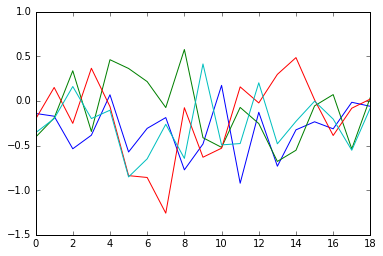

In [31]:
plt.plot(filters[11].T)

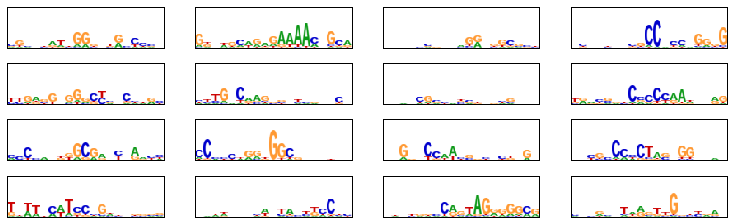

In [32]:
import matplotlib as mpl
import impress

num_filters = filters.shape[0]
grid = mpl.gridspec.GridSpec(4, 4)
grid.update(wspace=0.2, hspace=0.2, left=0.1, right=0.2, bottom=0.1, top=0.2)
fig = plt.figure(figsize=(100,30));
for i in range(num_filters):
    plt.subplot(grid[i]);
    norm_filter = impress.normalize_pwm(filters[i], factor=3)
    logo = impress.seq_logo(norm_filter, height=25, nt_width=10)
    plt.imshow(logo, interpolation='none')
    plt.yticks([])
    plt.xticks([])
    

# Let's generate a saliency map

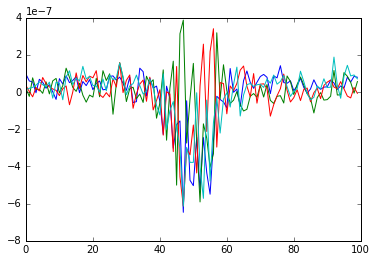

In [37]:
# let's get the highest predicted sequence 
max_index = np.argsort(test_predict[:,0])[::-1]

# get sequence
index = 1
X = np.expand_dims(X_test[max_index[index]], axis=0)

# calculate the gradients to the inputs
grad_to_inputs = tf.gradients(predictions, inputs)

# run the session to calculate the saliency map for a given sequence X
backprop_saliency = sess.run(grad_to_inputs, feed_dict={inputs: X, 
                                                        keep_prob_conv: 1.0, 
                                                        keep_prob_dense: 1.0})

plt.plot(np.squeeze(backprop_saliency[0]))

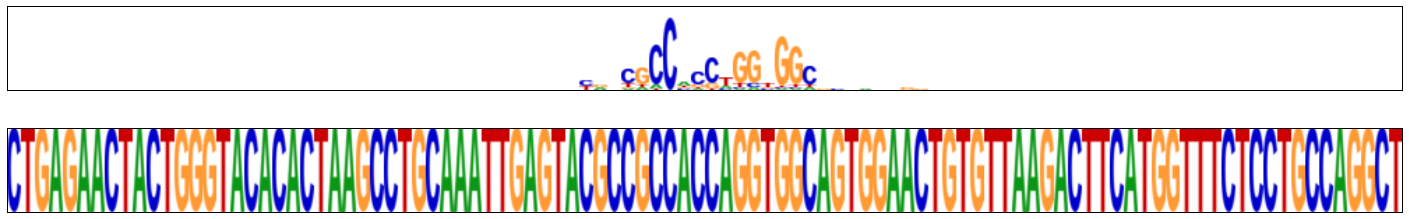

In [41]:
import impress

# filter and normalize saliency map 
norm_saliency = impress.normalize_pwm(np.squeeze(backprop_saliency[0]).T, factor=3)

# generate sequence logo
logo = impress.seq_logo(norm_saliency, height=30, nt_width=10, norm=0)

seq = impress.seq_logo(np.squeeze(X).T, height=30, nt_width=10, norm=0)

# plot sequence logo
plt.figure(figsize=(25,4))
plt.subplot(2,1,1)
plt.imshow(logo)
plt.xticks([]);
plt.yticks([]);
plt.subplot(2,1,2)
plt.imshow(seq)
plt.xticks([]);
plt.yticks([]);